In [1]:
import sys, os, time
# %load_ext autoreload
# %autoreload 2
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from IPython import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision
from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn
#from foundation.util import replicate, Cloner

from hybrid import get_model, get_data
from analyze import *

np.set_printoptions(linewidth=120, suppress=True)

In [2]:
# dataset = train.get_dataset('cr-3dshapes', dataroot=os.environ['FOUNDATION_DATA_DIR'], train=True)
# len(dataset)

In [3]:
dataset = trn.get_dataset('byfactor', factor='shape', counts=[4,20,0,0], labeled=True)
len(dataset)

Loading dataset: byfactor
factor: shape
vals: None (by default)
counts: [4, 20, 0, 0]
seeds: None (by default)
det: True (by default)
labeled: True
dataroot: /is/ei/fleeb/workspace/local_data
load_memory: True (by default)
train: True (by default)
labeled: True
noise: None (by default)
din: (3, 64, 64) (by default)
dout: 6 (by default)
Filtering out 383976/384000 samples


24

In [4]:
C = trn.get_config()
C.dataset.name = 'byfactor'
C.dataset.factor = 'shape'
C.dataset.counts = [12,0,0,0]
C.dataset.labeled = True



In [5]:
C.dataset._transfer = C.dataset.copy()
C.dataset._transfer.counts = [0,4,0,0]
C.dataset._mod = 'transfer'
trn.render_dict(C)

In [ ]:
dataset = trn.get_dataset(info=C.dataset)

In [4]:
# dataset = train.get_dataset('nocap-3dshapes', dataroot=os.environ['FOUNDATION_DATA_DIR'], negative=True)
len(dataset)

12

In [5]:
idx = np.random.randint(len(dataset), size=16)
idx = np.arange(16)
idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

<IPython.core.display.Javascript object>


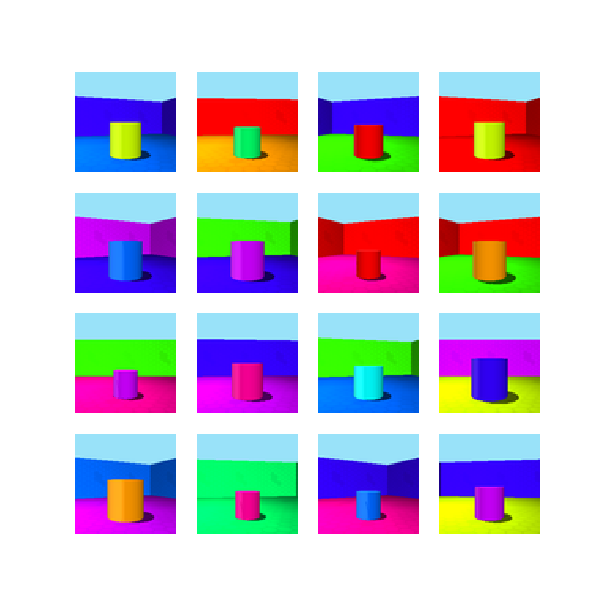

torch.Size([16, 6])


In [22]:
samples = [dataset[i] for i in idx]
if len(samples[0]) > 1:
    X, Y = zip(*samples)
    X = torch.stack(X)
    Y = torch.stack(Y)
else:
    X = torch.stack([s[0] for s in samples])
    Y = None
show_nums(X)
if Y is not None:
    print(Y.shape)
else:
    print(X.shape)

<IPython.core.display.Javascript object>


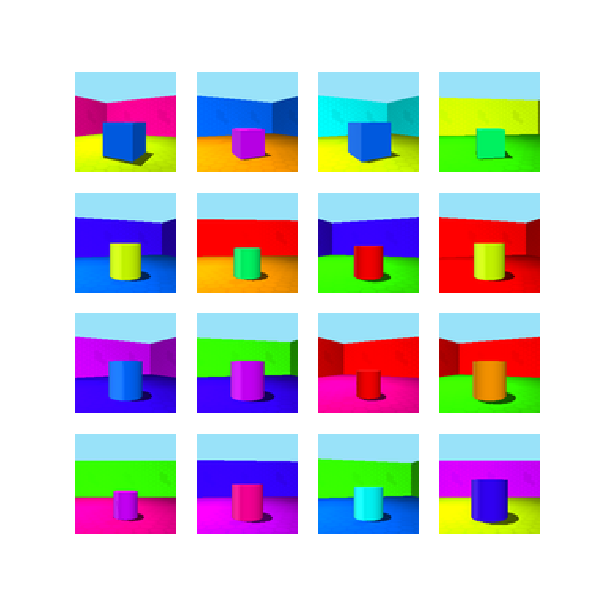

torch.Size([16, 6])


In [24]:
samples = [dataset[i] for i in idx]
if len(samples[0]) > 1:
    X, Y = zip(*samples)
    X = torch.stack(X)
    Y = torch.stack(Y)
else:
    X = torch.stack([s[0] for s in samples])
    Y = None
show_nums(X)
if Y is not None:
    print(Y.shape)
else:
    print(X.shape)

In [8]:
self = dataset

In [9]:
sel = torch.logical_not(self.labels[:, 2].isclose(torch.tensor(0.))
       + self.labels[:, 2].isclose(torch.tensor(0.3))
       + self.labels[:, 2].isclose(torch.tensor(0.7))) * self.labels[:, -2].isclose(torch.tensor(2.))

rep = (self.labels[:, 2].isclose(torch.tensor(0.))
        + self.labels[:, 2].isclose(torch.tensor(0.3))
        + self.labels[:, 2].isclose(torch.tensor(0.7))) * self.labels[:, -2].isclose(torch.tensor(2.))

replacements = self.images[rep]
replacements.shape

torch.Size([28809, 3, 64, 64])

In [31]:
sidx = torch.arange(self.images.shape[0])[sel]
ridx = torch.arange(self.images.shape[0])[rep]
sidx.shape, ridx.shape

(torch.Size([67201]), torch.Size([28809]))

In [33]:
lost = sel.sum().item()
swaps = rep.sum().item()
lost, swaps

(67201, 28809)

In [34]:
copies, extra = lost // swaps, lost % swaps

In [35]:
extra_idx = torch.randperm(swaps)[:extra]
extra_idx.shape

torch.Size([9583])

In [38]:
reps = torch.cat([ridx]*copies + [extra_idx])
reps.shape

torch.Size([67201])

In [39]:
self.images[sidx] = self.images[reps]

tensor(67201)

In [13]:
67201 / replacements.shape[0]

2.332639105834982

In [15]:
67201 % replacements.shape[0]

9583

In [ ]:
9583

In [ ]:
torch.randperm()

In [3]:
dataset = train.get_dataset('z-celeba', dataroot=os.environ['FOUNDATION_DATA_DIR'], label_type='attr')

NameError: name 'train' is not defined

In [ ]:
i = np.random.randint(len(dataset))

In [ ]:
x, y = dataset[i]
x.shape, y.shape

In [ ]:
plt.imshow(x.permute(1,2,0).numpy())

In [9]:
import h5py as hf

In [6]:
root = os.environ['FOUNDATION_DATA_DIR']
dnames = os.listdir(root)
dataroot = os.path.join(root, '3dshapes')

In [ ]:
path = dataroot
os.listdir(dataroot)

In [10]:
path = os.path.join(dataroot, '3dshapes_train.h5')
f = hf.File(path, 'r+')
list(f.keys())

['images', 'labels']

In [12]:
f['labels'].shape, f['images'].shape

((384000, 6), (384000, 64, 64, 3))

In [15]:
f.attrs.keys()

<KeysViewHDF5 ['factor_order', 'factor_sizes']>